C:\Users\craig\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\craig\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\craig\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


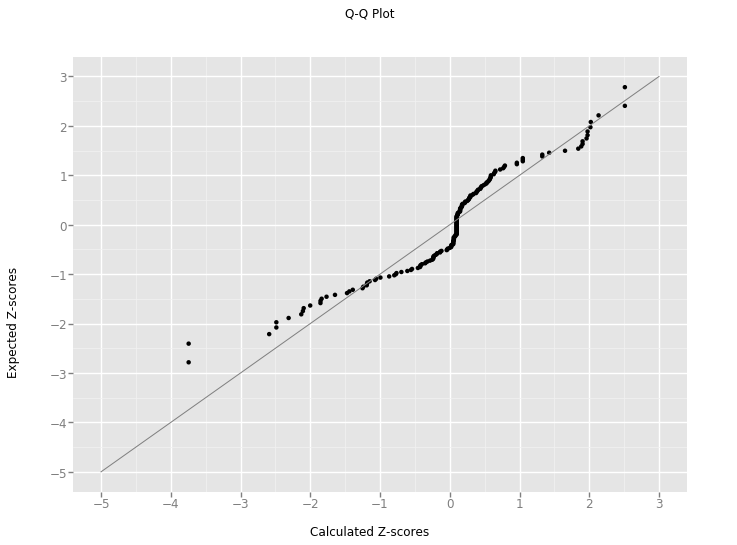

<ggplot: (87543495337)>


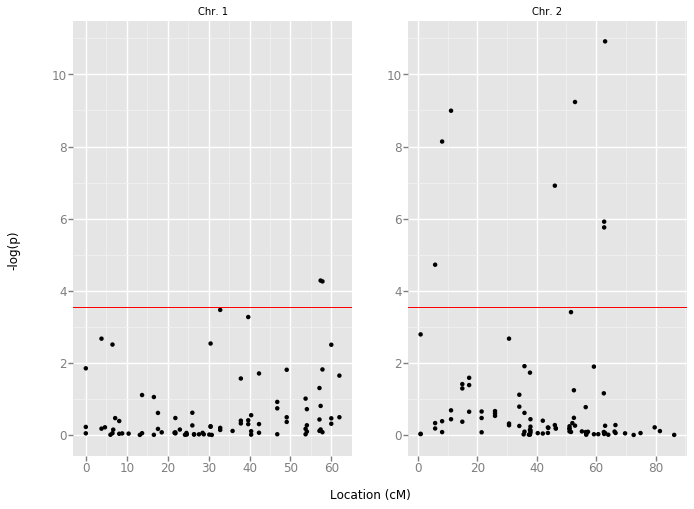

<ggplot: (-9223371949310938466)>


Chromosome       Locus   Position             p
6          2  D2M15 - MT  63.029291  1.211744e-11
3          2   D2M8 - MT  52.893977  5.826973e-10
9          2  D2M19 - MT  11.151895  1.016244e-09
8          2  D2M18 - MT    8.14509  7.270257e-09
2          2   D2M6 - MT  46.102807  1.218632e-07
5          2  D2M14 - MT  62.709469  1.213753e-06
4          2  D2M14 - MM  62.709469  1.751022e-06
7          2  D2M17 - MT   5.793198  1.897326e-05
0          1  D1M24 - MT  57.367016  5.212514e-05
1          1  D1M25 - MT  57.811679  5.505264e-05

In [1]:
def simpleANOVA(data):
    import scipy.stats
    
    total_average = 0
    total_n = 0
    group_averages = []
    group_n = []
    
    for i in data:
        temp_average = 0
        temp_n = 0
        for j in i:
            total_average = total_average + j
            total_n = total_n + 1
            temp_average = temp_average + j
            temp_n = temp_n + 1
        if temp_n > 0:
            temp_average = temp_average / temp_n
            group_averages.append(temp_average)
            group_n.append(temp_n)
        else:
            group_averages.append(0)
            group_n.append(0)
    
    total_average = total_average / total_n
    
    SST = 0
    for i in data:
        for j in i:
            SST = SST + (j - total_average) ** 2
            
    SSB = 0
    for i, j in enumerate(data):
        mean = group_averages[i]
        n = len(j)
        SSB = SSB + n * (mean - total_average) ** 2
    
    SSE = SST - SSB
    dfSSB = len(data) - 1
    dfSSE = total_n - len(data)
    MSB = SSB / dfSSB
    MSE = SSE / dfSSE
    if MSE == 0:
        return {"F": float('inf'), "p": 0}
    
    F = MSB / MSE
    p = scipy.stats.f.sf(F, dfSSB, dfSSE)
      
    return {"F": F, "p": p}


import csv
import re
import statistics
import scipy.stats
import numpy
import pandas
import math
from ggplot import *

"""
ERRORS TO CHECK FOR

duplicate line names (will just be rewritten write now)
check to make sure line and average are correct column names
"""

"""
Input variables
    Phenotype file name and location
    Genotype file name and location
    Allele 1
    Allele 2
    Allele Error
"""

genotype_filename = "C:/Users/craig/CSB/Final_Project/csb_final_project/DataSet1.csv"
phenotype_filename = "C:/Users/craig/CSB/Final_Project/csb_final_project/GenotypeSetShort.csv"
allele1 = "M"
allele2 = "T"
allele_bad = "N"

homo1 = allele1 + allele1
homo2 = allele2 + allele2
hetero1 = allele1 + allele2
hetero2 = allele2 + allele1

possible_genotypes = (homo1, homo2, hetero1)


data = {}
with open(genotype_filename) as gf:
    reader = csv.DictReader(gf)
    for i, entry in enumerate(gf):
        if i is 0:
            is_first_col = re.split(r",", entry)[0].lower() == "line"
            is_second_col = re.findall(r"(.*)\n?", re.split(r",", entry)[-1])[0].lower() == "average"
        elif i is not 0:
            temp_line = re.split(r",", entry)[0]
            temp_average = re.findall(r"(.*)\n?", re.split(r",", entry)[-1])[0]
            data[temp_line] = temp_average
    gf.close()

list_loci_info = []
loci_data = {}
genotypes = {}
with open(phenotype_filename) as pf:
    reader = csv.DictReader(pf)
    for i, entry in enumerate(pf):
        values = re.split(r",", re.findall(r"(.+)\n?", entry)[0])
        if i < 3:
            for i, value in enumerate(values):
                if i is not 0:
                    temp_loci_data = {}
                    for genotype in possible_genotypes:
                        temp_loci_data[genotype] = {'n': 0, 'mean': 0, 'stdev': 0, 'values': []}
                    try:
                        list_loci_info[i - 1].append(value)
                    except IndexError:
                        list_loci_info.append([])
                        list_loci_info[i - 1].append(value)
                        loci_data[value] = temp_loci_data
        else:
            line = values.pop(0)
            genotypes[line] = {}
            for i, value in enumerate(values):
                genotypes[line][list_loci_info[i][0]] = value
    pf.close()

loci_info = {}
for loci in list_loci_info:
    loci_info[loci[0]] = loci[1:]

for loci in loci_data:
    for line in genotypes:
        genotype = genotypes[line][loci]
        if genotype == hetero2:
            genotype = hetero1
        if genotype != allele_bad:
            loci_data[loci][genotype]['values'].append(float(data[line]))

for loci in loci_data:
    for genotype in possible_genotypes:
        count = len(loci_data[loci][genotype]['values'])
        loci_data[loci][genotype]['n'] = count
        if count < 1:
            loci_data[loci][genotype]['mean'] = 0
            loci_data[loci][genotype]['stdev'] = 0
        else: 
            loci_data[loci][genotype]['mean'] = statistics.mean(loci_data[loci][genotype]['values'])
            if count == 1:
                loci_data[loci][genotype]['stdev'] = 0
            else:
                loci_data[loci][genotype]['stdev'] = statistics.stdev(loci_data[loci][genotype]['values'])

means = []
for i in loci_data:
    for j in loci_data[i]:
        if loci_data[i][j]['n'] > 1:
            means.append(loci_data[i][j]['mean'])

total_mean = statistics.mean(means)
total_sd = statistics.stdev(means)

expected = []
actual = []
means.sort()

for i, j in enumerate(means):
    expected.append(scipy.stats.norm.ppf((i + 0.5) / len(means)))
    actual.append((j - total_mean) / total_sd)

df = pandas.DataFrame({"x": actual, "y": expected})
qplt = ggplot(df, aes('x', 'y')) +\
    geom_point() +\
    geom_abline(slope = 1, color = "grey") +\
    xlab("Calculated Z-scores") +\
    ylab("Expected Z-scores") +\
    ggtitle("Q-Q Plot")
print(qplt)

useful_data = {}
for i in loci_data:
    for j in loci_data[i]:
        useful_data[i + " - " + j] = loci_data[i][j]

data = []
for i in useful_data:
    data.append(useful_data[i]['values'])

output = simpleANOVA(data)

p = output['p']

pvalues = {}
for i in loci_data:
    data = []
    if len(loci_data[i]) > 1:
        for j in loci_data[i]:
            data.append(loci_data[i][j]['values'])
        pvalues[i] = simpleANOVA(data)['p']

pvalues = {}
for t, i in enumerate(useful_data):    
    current = useful_data[i]['values']
    outgroup = []
    for j in useful_data:
        if i != j:
            for k in useful_data[j]['values']:
                outgroup.append(k)

    differences = []
    bootstrap_count = 10
    if len(current) > 3:
        for k in range(bootstrap_count):
            current_sample = []
            outgroup_sample = []
            
            sample_size = 100
            indices = numpy.random.randint(len(current), size = sample_size)
            for k in indices:
                current_sample.append(current[k])
                
            indices = numpy.random.randint(len(outgroup), size = sample_size)
            for k in indices:
                outgroup_sample.append(outgroup[k])
            
            differences.append(statistics.mean(current_sample) - statistics.mean(outgroup_sample))
    
    if len(differences) == bootstrap_count:
        current_z = statistics.mean(differences) / statistics.stdev(differences)
        current_p = scipy.stats.norm.sf(abs(current_z)) * 2
        pvalues[i] = current_p
            
location = []
p = []
for i in pvalues:
    location.append(i)
    p.append(-math.log10(pvalues[i]))

d = {'location': location, "-log(p)": p}
df = pandas.DataFrame(d)

location = []
p = []
chromosome = []
for i in pvalues:
    key = re.findall(r'(.*)\s-\s', i)[0]
    location.append(float(loci_info[key][1]))
    p.append(-math.log10(pvalues[i]))
    chromosome.append("Chr. " + str(loci_info[key][0]))

d = {'Location (cM)': location, "-log(p)": p, "chromosome": chromosome}
df = pandas.DataFrame(d)

alpha = 0.05
significance = -math.log10(alpha / len(pvalues))
plt = ggplot(df, aes('Location (cM)', '-log(p)')) +\
    geom_point(color = 'black') +\
    geom_hline(aes(color = "red"), y = significance) +\
    facet_wrap("chromosome", nrow = 1, scales = "free_x")

print(plt)

loci = []
ps = []
chromosomes = []
positions = []
ns = []
for i in pvalues:
    if pvalues[i] < (10 ** -significance):
        loci.append(i)
        ps.append(pvalues[i])
        key = re.findall(r'(.*)\s-\s', i)[0]
        chromosomes.append(loci_info[key][0])
        positions.append(loci_info[key][1])

sig_l = {"Locus": loci, "Position": positions, "Chromosome": chromosomes, "p": ps}
significant_loci = pandas.DataFrame(sig_l).sort_values(by = ['p'])

significant_loci

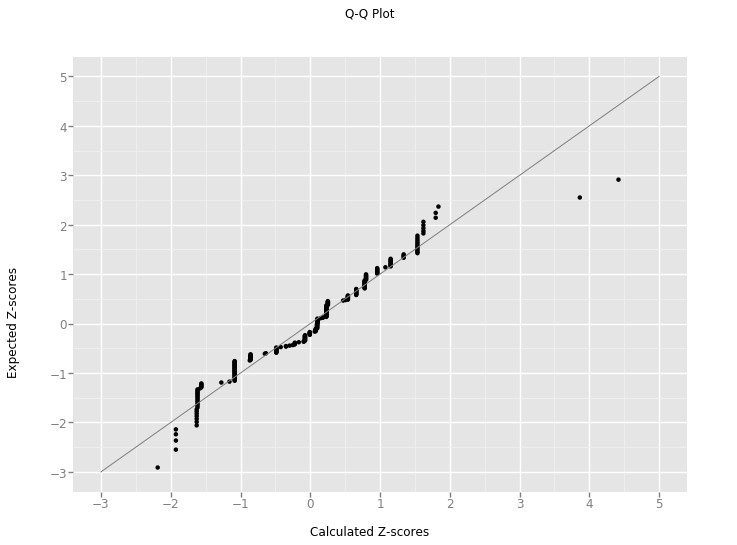

<ggplot: (125945570473)>

In [4]:
means = []
for i in loci_data:
    for j in loci_data[i]:
        if loci_data[i][j]['n'] > 1:
            means.append(loci_data[i][j]['mean'])

total_mean = statistics.mean(means)
total_sd = statistics.stdev(means)

expected = []
actual = []
means.sort()
for i, j in enumerate(means):
    expected.append(scipy.stats.norm.ppf((i + 0.5) / len(means)))
    actual.append((j - total_mean) / total_sd)

df = pandas.DataFrame({"x": actual, "y": expected})
qplt = ggplot(df, aes('x', 'y')) +\
    geom_point() +\
    geom_abline(slope = 1, color = "grey") +\
    xlab("Calculated Z-scores") +\
    ylab("Expected Z-scores") +\
    ggtitle("Q-Q Plot")
qplt

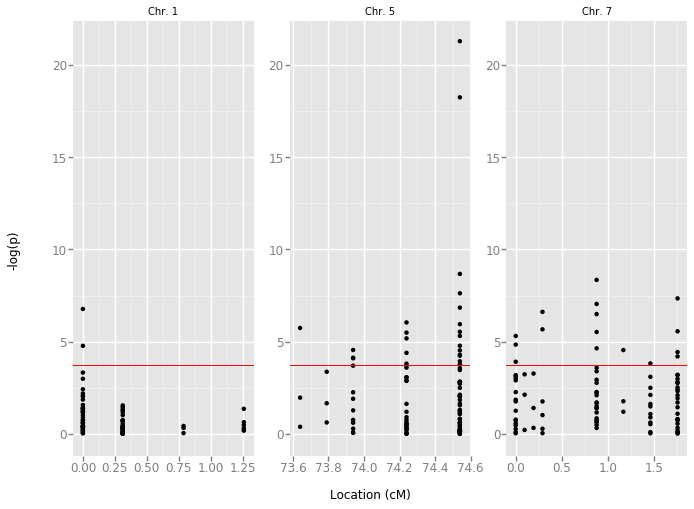

<ggplot: (123318100246)>

In [29]:
location = []
p = []
chromosome = []
for i in pvalues:
    key = re.findall(r'(.*)\s-\s', i)[0]
    location.append(float(loci_info[key][1]))
    p.append(-math.log10(pvalues[i]))
    chromosome.append("Chr. " + str(loci_info[key][0]))

d = {'Location (cM)': location, "-log(p)": p, "chromosome": chromosome}
df = pandas.DataFrame(d)

plt = ggplot(df, aes('Location (cM)', '-log(p)')) +\
    geom_point(color = 'black') +\
    geom_hline(aes(color = "red"), y = significance) +\
    facet_wrap("chromosome", nrow = 1, scales = "free_x")

plt

In [22]:
loci = []
ps = []
chromosomes = []
positions = []
for i in pvalues:
    if pvalues[i] < (10 ** -significance):
        loci.append(i)
        ps.append(pvalues[i])
        key = re.findall(r'(.*)\s-\s', i)[0]
        chromosomes.append(loci_info[key][0])
        positions.append(loci_info[key][1])

sig_l = {"Locus": loci, "Position": positions, "Chromosome": chromosomes, "p": ps}
significant_loci = pandas.DataFrame(sig_l).sort_values(by = ['p'])

significant_loci

Chromosome         Locus     Position              p
672           5   D5M738 - MT  35.06041593  3.768361e-252
918           5   D5M945 - MT  63.78228275  3.507637e-249
694           5   D5M770 - MT  43.78990077  6.086754e-249
898           5   D5M935 - MT  63.78228175  2.104177e-242
936           5   D5M954 - MT  63.78232703  1.037205e-240
926           5   D5M949 - MT  63.78228315  9.752128e-240
914           5   D5M943 - MT  63.78228255  1.566676e-239
912           5   D5M942 - MT  63.78228245  7.598604e-239
900           5   D5M936 - MT  63.78228185  1.315736e-238
1588          5  D5M1237 - MT  74.53890373  1.007430e-237
690           5   D5M766 - MT  43.32281137  1.940678e-237
670           5   D5M737 - MT  31.56860799  8.218745e-237
876           5   D5M924 - MT  63.48912881  3.259885e-236
922           5   D5M947 - MT  63.78228295  5.034986e-236
697           5   D5M773 - MT  44.72864224  1.232079e-234
916           5   D5M944 - MT  63.78228265  1.994536e-233
886           5   D5M929 - MT  63.78228115  2.795807e-232
932           5   D5M952 - MT  63.78228345  6.991967e-232
878           5   D5M925 - MT  63.58644465  2.130285e-231
920           5   D5M946 - MT  63.78228285  1.332909e-230
890           5   D5M931 - MT  63.78228135  1.966672e-227
674           5   D5M739 - MT  38.98299712  2.025898e-226
892           5   D5M932 - MT  63.78228145  2.307522e-226
884           5   D5M928 - MT  63.78228105  3.085708e-225
906           5   D5M939 - MT  63.78228215  3.108309e-225
696           5   D5M772 - MT  43.78994436  4.047012e-225
896           5   D5M934 - MT  63.78228165  4.573633e-225
888           5   D5M930 - MT  63.78228125  1.740698e-224
695           5   D5M771 - MT  43.78990087  1.770694e-224
689           5   D5M765 - MT  43.32276789  5.849008e-222
...         ...           ...          ...            ...
369           1   D5M286 - TT  25.12498811   7.249164e-06
2255          7   D7M423 - MT  11.14314882   7.490309e-06
1375          5  D5M1144 - MM  70.55670589   7.673556e-06
1362          5  D5M1139 - MT  70.55670539   8.091732e-06
585           5   D5M674 - MM   4.45442165   8.209451e-06
1380          5  D5M1145 - MT  70.55670599   8.420757e-06
1291          5  D5M1113 - MT  69.30324165   8.594818e-06
2172          7   D7M360 - MM  10.21733253   8.601494e-06
265           1   D5M246 - MM  18.72735728   8.650091e-06
454           5   D5M615 - MM     1.80E-06   8.657715e-06
27            1    D5M72 - MT   5.31825649   8.764792e-06
1062          5  D5M1016 - MM  64.94702124   8.830680e-06
987           5   D5M980 - MM  64.94701764   8.924095e-06
2256          7   D7M424 - MT  11.14314892   8.926383e-06
647           5   D5M710 - TT  16.66832386   9.185901e-06
557           5   D5M657 - TT   3.93170726   9.603512e-06
1747          7    D7M92 - MT  3.856458534   9.624901e-06
762           5   D5M851 - TT  59.19540993   9.633759e-06
2257          7   D7M427 - MT  11.14314922   9.729635e-06
29            1    D5M74 - TT  5.318300074   9.948656e-06
1106          5  D5M1035 - MM   65.3155314   1.000331e-05
1092          5  D5M1030 - MM   65.3155309   1.005723e-05
23            1    D5M20 - MT   0.31171691   1.026804e-05
31            1    D5M75 - TT  5.910645803   1.030640e-05
561           5   D5M659 - TT   3.93170746   1.067982e-05
2154          7   D7M347 - MM  9.906773554   1.072085e-05
2234          7   D7M400 - MM  10.53072201   1.092859e-05
2251          7   D7M417 - MT  11.14314822   1.093731e-05
725           5   D5M815 - TT  58.26919722   1.130355e-05
97            1   D5M142 - MT  9.371231204   1.136016e-05

[2304 rows x 4 columns]

22.410363333873 0.6028914970823411
22.766089999739 0.6773818325403473
4.2731286608e-34
1000
Ttest_indResult(statistic=-12.404945446321339, pvalue=4.2731286607988849e-34)


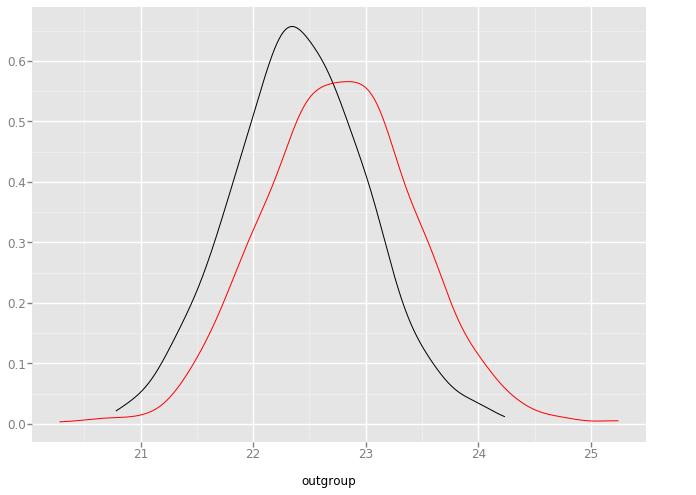

<ggplot: (123319192510)>

In [40]:
import pandas
from scipy import stats

p = stats.ttest_ind_from_stats(mean1 = statistics.mean(current_sample_means),
                           std1 = statistics.stdev(current_sample_means),
                           nobs1 = len(current_sample_means), 
                           mean2 = statistics.mean(outgroup_sample_means),
                           std2 = statistics.stdev(outgroup_sample_means),
                           nobs2 = len(outgroup_sample_means))
                           
                           
print(statistics.mean(current_sample_means), statistics.stdev(current_sample_means))
print(statistics.mean(outgroup_sample_means), statistics.stdev(outgroup_sample_means))
print(current_p)
print(len(current_sample_means))
print(p)

values = []
for i in range(1000):
    values.append(current_sample_means[i] - outgroup_sample_means[i])

df = pandas.DataFrame({"current": current_sample_means, "outgroup": outgroup_sample_means})
plt = ggplot(df, aes('current')) +\
    geom_density(color = 'black') +\
    geom_density(aes('outgroup'), color = 'red')


print(plt)

-0.39221047691648836
0.347451351797


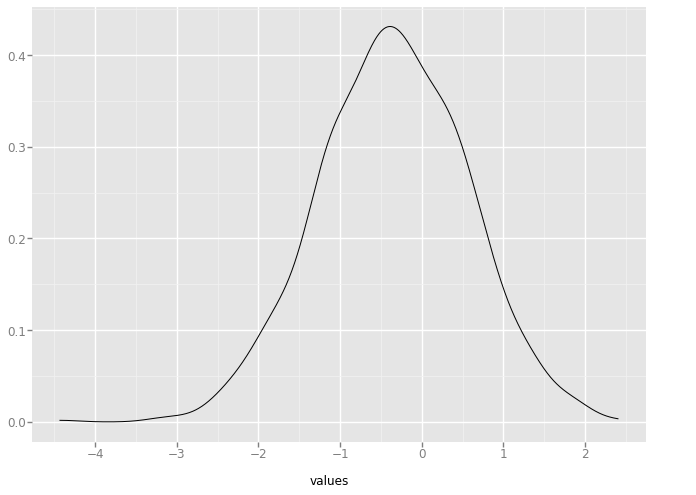

<ggplot: (123325986312)>

In [80]:
from scipy import stats
import numpy
values = []
for i in range(1000):
    values.append(current_sample_means[i] - outgroup_sample_means[i])

z = (statistics.mean(values) / statistics.stdev(values))
print(z)
print(stats.norm.sf(abs(z)))
df = pandas.DataFrame({"values": values})
plt = ggplot(df, aes('values')) +\
    geom_density(color = 'black')
plt

In [86]:
%pdb

Automatic pdb calling has been turned ON


In [4]:
a, b, c = [1, 2, 3]

In [18]:
from tkinter import *

In [40]:
display(significant_loci)

Chromosome       Locus   Position             p
6          2  D2M15 - MT  63.029291  1.211744e-11
3          2   D2M8 - MT  52.893977  5.826973e-10
9          2  D2M19 - MT  11.151895  1.016244e-09
8          2  D2M18 - MT    8.14509  7.270257e-09
2          2   D2M6 - MT  46.102807  1.218632e-07
5          2  D2M14 - MT  62.709469  1.213753e-06
4          2  D2M14 - MM  62.709469  1.751022e-06
7          2  D2M17 - MT   5.793198  1.897326e-05
0          1  D1M24 - MT  57.367016  5.212514e-05
1          1  D1M25 - MT  57.811679  5.505264e-05